# Raw CaloClouds

Trying to diagnose an issue with the output distirbutions of Showflow + CaloClouds.
This notebook will run Caloclouds using inputs from G4 data rather than showerflow.
Minimal post processing is done before opening the plots.

In [1]:
from pointcloud.evaluation import caloclouds_raw
from pointcloud.config_varients import wish_maxwell, caloclouds_3_simple_shower, bug_dip
from matplotlib import pyplot as plt
import numpy as np
import os

In [22]:
wish_config = wish_maxwell.Configs()
config = caloclouds_3_simple_shower.Configs()
config.device = 'cpu'
config.logdir = wish_config.logdir
config.storage_base = wish_config.storage_base
config.cond_features = 4
config.cond_features_names = ["energy", "p_norm_local"]
config.shower_flow_cond_features = config.cond_features_names

#config._dataset_path = wish_config._dataset_path
#config.dataset_path = "/home/dayhallh/Data/fake_increments_10.npz"


In [23]:
raw_samples_dir = os.path.join(config.logdir, "caloclouds_raw_samples")
if not os.path.exists(raw_samples_dir):
    os.mkdir(raw_samples_dir)
    
def sample_save_name(model_name, n_points):
    model_base = '.'.join(os.path.basename(model_name).split('.')[:-1])
    save_name = os.path.join(raw_samples_dir, f"{model_base}_{n_points}.npz")
    return save_name
    
    

In [24]:
redo_data = False
varients = {}

model_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/p22_th90_ph90_en10-100/CD_2024_07_23__11_59_44/ckpt_0.342419_1540000.pt"
varients["old ghenry"] = (model_path, wish_config.dataset_path, 1000, None, None)
model_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/investigation2/CD__p22_th90_ph90_en10-1002024_12_11__18_27_01/ckpt_0.487173_140000.pt"
varients["redone ghenry"] = (model_path, wish_config.dataset_path, 1000, None, None)
model_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/investigation2/CD_sim-E1261AT600AP180-1802024_12_16__19_08_57/ckpt_0.392248_380000.pt"
varients["redone sim"] = (model_path, config.dataset_path, 1000, None, None)
#model_path = "/data/dust/user/akorol/maxwell.merged/logs/point-clouds-angular/CD_ClusteredDS_Pretrained2024_03_27__00_23_43/ckpt_0.000000_1130000.pt"
#varients["new Anatolii"] = (model_path, config.dataset_path, 1000, None, None)
#model_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/wish/CD_2024_08_23__13_39_15/ckpt_28.587090_30000.pt"
#varients[model_path] = ("/home/dayhallh/Data/fake_increments_10.npz", 1000, None, None)
#model_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/wish/CD_2024_08_23__14_43_56/ckpt_14.732546_10000.pt"
#varients[model_path] = ("/home/dayhallh/Data/fake_increments_10_to0.npz", 1000, None, None)


for name in varients:
    print(model_path)
    model_path = varients[name][0]
    config.dataset_path = varients[name][1]
    n_events = varients[name][2]
    file_name = sample_save_name(model_path, n_events)
    print(file_name)
    if os.path.exists(file_name) and not redo_data:
        print("Existing data")
        loaded = np.load(file_name)
        hits_per_layer = loaded["hits_per_layer"]
        points = loaded["points"]
        varients[name] = (model_path, config.dataset_path, n_events, points, hits_per_layer)
    else:
        print("Redoing data")
        hits_per_layer, points = caloclouds_raw.process_events(model_path, config, n_events)
        varients[name] = (model_path, config.dataset_path, n_events, points, hits_per_layer)
        np.savez(file_name, hits_per_layer=hits_per_layer, points=points)

/data/dust/user/dayhallh/point-cloud-diffusion-logs/investigation2/CD_sim-E1261AT600AP180-1802024_12_16__19_08_57/ckpt_0.392248_380000.pt
/home/dayhallh/training/point-cloud-diffusion-logs/wish/caloclouds_raw_samples/ckpt_0.342419_1540000_1000.npz
Existing data
/data/dust/user/dayhallh/point-cloud-diffusion-logs/p22_th90_ph90_en10-100/CD_2024_07_23__11_59_44/ckpt_0.342419_1540000.pt
/home/dayhallh/training/point-cloud-diffusion-logs/wish/caloclouds_raw_samples/ckpt_0.487173_140000_1000.npz
Existing data
/data/dust/user/dayhallh/point-cloud-diffusion-logs/investigation2/CD__p22_th90_ph90_en10-1002024_12_11__18_27_01/ckpt_0.487173_140000.pt
/home/dayhallh/training/point-cloud-diffusion-logs/wish/caloclouds_raw_samples/ckpt_0.392248_380000_1000.npz
Redoing data


In [25]:
n_events = 1000
n_files = 10
dataloaders = ["PointCloudDatasetUnordered", "PointCloudDataset", "PointCloudAngular"]
for dataloader in dataloaders:
    hits_per_layer, points = caloclouds_raw.process_events(config.dataset_path, config, n_events, "PointCloudDatasetUnordered", n_files)
    varients[dataloader] = (dataloader, config.dataset_path, n_events, points, hits_per_layer)

In [26]:
# make a mask that removes leading and trailing zeros

tails_mask = {title: np.ones(varients[title][3].shape[:-1], dtype=bool) for title in varients}
for title in varients:
    points = varients[title][3]
    mask = tails_mask[title]
    for r, event in enumerate(points):
        print(f"{r/n_events:.1%}", end='\r')
        leading_zeros = next((i for i, p in enumerate(event[:, 3]) if p!=0), 0)
        trailing_zeros = next((i for i, p in enumerate(event[::-1, 3]) if p!=0), 0)
        mask[r, :leading_zeros] = False
        if trailing_zeros:
            mask[r, -trailing_zeros:] = False
        
        
    


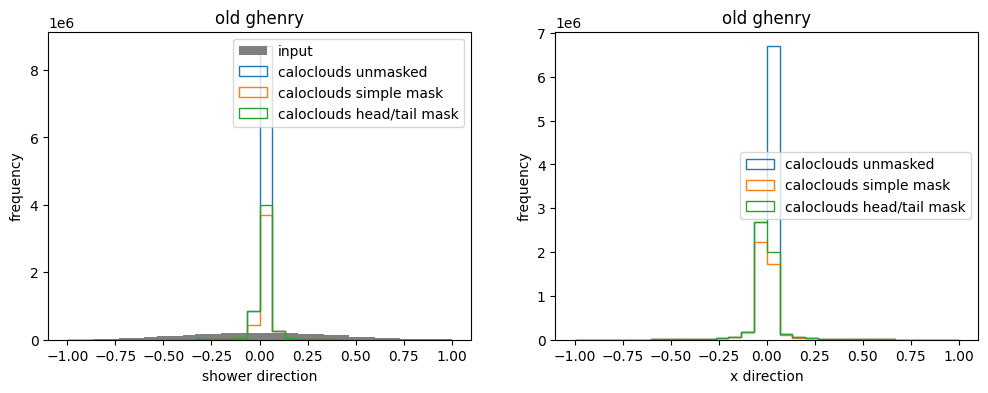

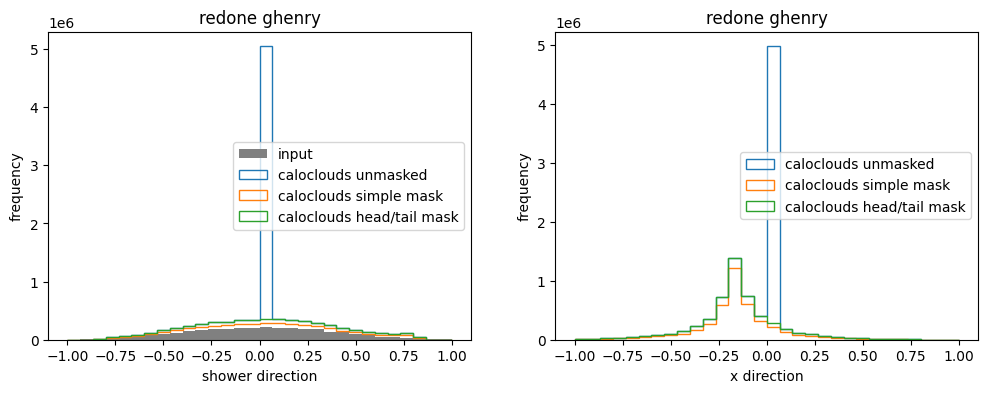

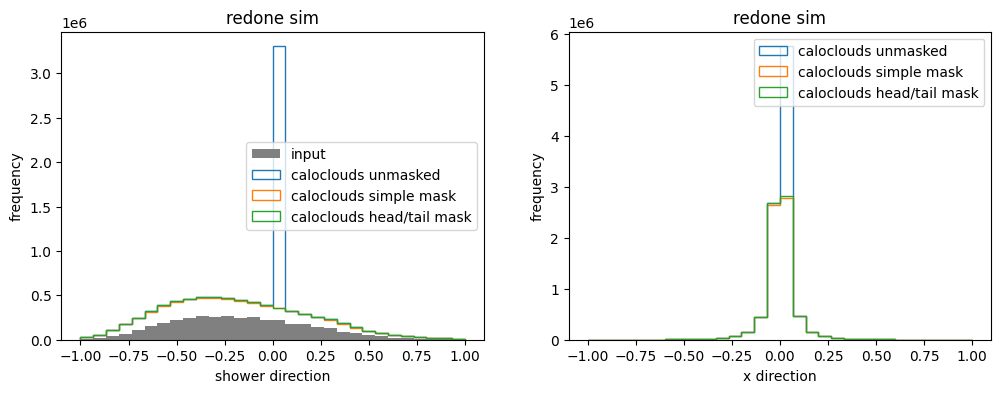

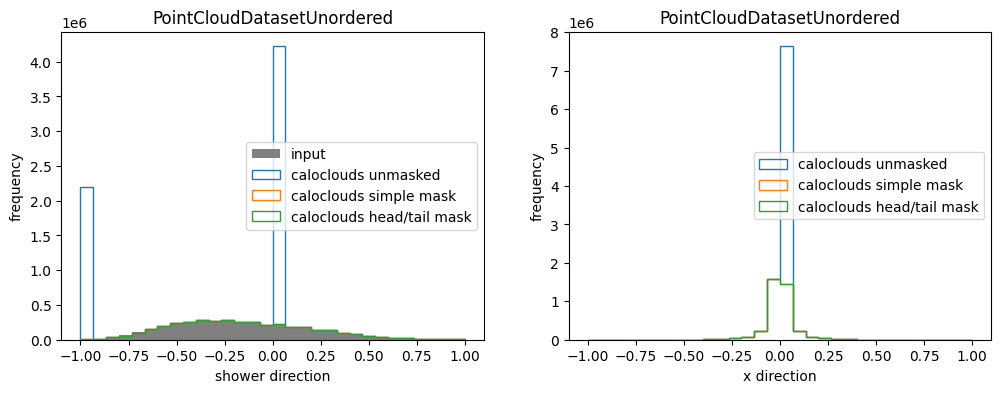

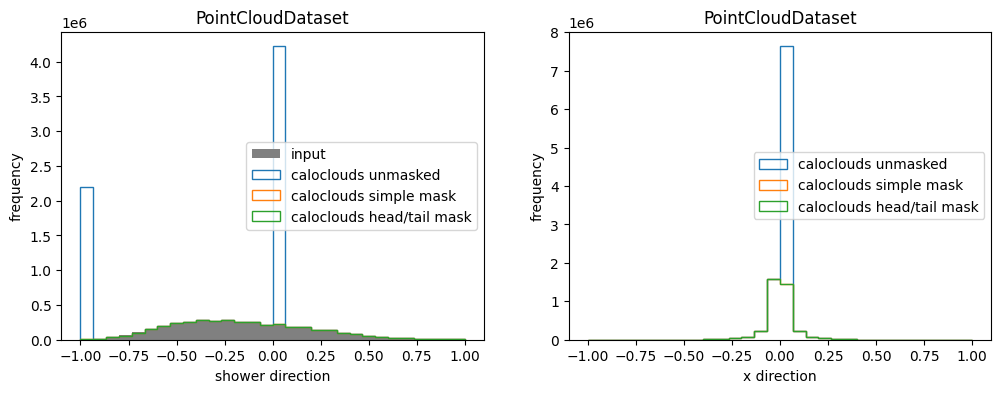

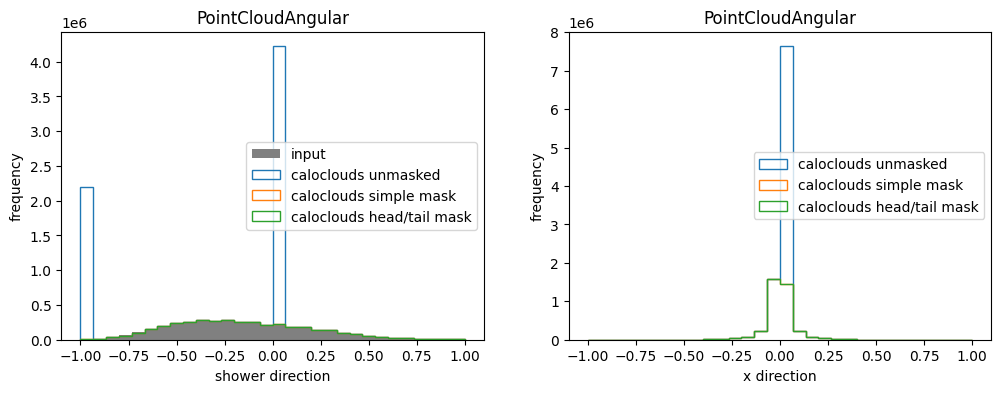

In [28]:

for title in varients:
    model_path, dataset_path, n_events, points, hits_per_layer = varients[title]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ax = axes[0]
    # plot the input
    sum_hist_per_layer = np.sum(hits_per_layer, axis=0)
    x_min, x_max = -1, 1
    layer_bins = np.linspace(x_min, x_max, 31)
    layer_xs = 0.5*(layer_bins[1:] + layer_bins[:-1])
    ax.hist(layer_xs, weights=sum_hist_per_layer, bins=layer_bins, label="input", color="grey")
    
    found_zs = points[:, :, 2].flatten()
    ax.hist(found_zs, histtype='step', label="caloclouds unmasked", bins=layer_bins)
    
    # plot the frequencies using a simple mask that removes any negative energies
    found_es = points[:, :, 3].flatten()
    masked_zs = found_zs[found_es>0]
    ax.hist(masked_zs, histtype='step', label="caloclouds simple mask", bins=layer_bins)
    
    # plot the frequncies, masking by removing only training zeros
    flat_mask = tails_mask[title].flatten()
    ax.hist(found_zs[flat_mask], histtype='step', label="caloclouds head/tail mask", bins=layer_bins)
    ax.legend()
    ax.set_xlabel("shower direction")
    ax.set_ylabel("frequency")
    ax.set_title(title)
    #ax.semilogy()
    #ax.set_ylim(1e3, 1e6) ax = axes[0]
    # plot the input
    ax = axes[1]
    found_xs = points[:, :, 0].flatten()
    ax.hist(found_xs, histtype='step', label="caloclouds unmasked", bins=layer_bins)
    
    # plot the frequencies using a simple mask that removes any negative energies
    masked_xs = found_xs[found_es>0]
    ax.hist(masked_xs, histtype='step', label="caloclouds simple mask", bins=layer_bins)
    
    # plot the frequncies, masking by removing only training zeros
    ax.hist(found_xs[flat_mask], histtype='step', label="caloclouds head/tail mask", bins=layer_bins)
    ax.legend()
    ax.set_xlabel("x direction")
    ax.set_ylabel("frequency")
    ax.set_title(title)
    #ax.semilogy()
    #ax.set_ylim(1e3, 1e6)

